## Iceberg vs Ships
---
#### Versions
- v1: baseline, 0.29665 Public
- v2: Transfer learning. Not good.
- v3.0: k-fold, early stopping, callbacks
- v3.1: Tensorboard
- v4.0: Data augmentation
- v4.1: Denoising
- v4.2: MinMaxScaler
- v4.3: Revisit transfer learning
- v4.4: Final
---

### Imports and data loading

In [1]:
# Set env vars for TF. Do this before importing TF.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' # Bind to a specific GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Set TF logging level. 0 is default, 3 is nothing.

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import convolve, uniform_filter, median_filter,  percentile_filter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [3]:
# Generate confusion matrix plot
# matplotlib 3.1.1 has a bug, downgrade to 3.1.0
def plot_cm(actual, pred):
    cm_df = pd.DataFrame(confusion_matrix(actual, pred))
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cm_df, 
                annot=True, 
                annot_kws={'size': 24},
                fmt='d', 
                cbar=False,
                cmap='Blues', 
                ax=ax);

In [4]:
# Load the data
train_df = pd.read_json('data/train.json')
test_df = pd.read_json('data/test.json')
train_df

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",na,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",na,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",na,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",na,0


In [5]:
# Scale band_1 and band_2. Since band 3 is derived from these, it will be scaled automatically.
scaler = MinMaxScaler()
for df in [train_df, test_df]:
    df['band_1_scaled'] = df['band_1'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1,1)))
    df['band_2_scaled'] = df['band_2'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1,1)))

In [6]:
# Create new features by passing band_1 and band_2 through a median filter
for df in [train_df, test_df]:
    df['band_1_median'] = df['band_1_scaled'].apply(lambda x: median_filter(np.array(x).reshape(75,75), size=(6,6)))
    df['band_2_median'] = df['band_2_scaled'].apply(lambda x: median_filter(np.array(x).reshape(75,75), size=(6,6)))

In [7]:
# Create 4d array of images - indep var.
# Channel 1 is HH, channel 2 is HV, channel 3 is a product of both.
# https://earth.esa.int/c/document_library/get_file?folderId=409229&name=DLFE-5566.pdf
def create_4d_array(df):
    band_1_arr = np.array([np.array(band_1).reshape(75, 75) for band_1 in df['band_1_scaled']]).reshape(-1, 75, 75, 1)
    band_2_arr = np.array([np.array(band_2).reshape(75, 75) for band_2 in df['band_2_scaled']]).reshape(-1, 75, 75, 1)
    band_3_arr = (band_1_arr + band_2_arr)/2
#     band_3_arr = band_1_arr * band_2_arr # Try multiplying these again.
    return np.concatenate([band_1_arr, band_2_arr, band_3_arr], axis=3)

X_train_all = create_4d_array(train_df)
X_test = create_4d_array(test_df)

print(X_train_all.shape)
print(X_test.shape)
assert X_train_all.shape[0] == train_df.shape[0]
assert X_test.shape[0] == test_df.shape[0]

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [8]:
# Create training dep var
y_train_all = train_df['is_iceberg']

print(y_train_all.shape)
assert y_train_all.shape[0] == train_df.shape[0]

(1604,)


---
### Development and tuning

In [9]:
# Define the CNN
def get_model():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    return model

In [10]:
def get_xfer_model():
    transfer_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(75,75,3))
    transfer_model.trainable = False
    # transfer_model.summary()
    model = Sequential(transfer_model)

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [11]:
# Train/validation split for model tuning
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state=2020)
y_train, y_val = np.array(y_train), np.array(y_val)

In [12]:
# Tensorboard set up
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
# Define callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
             tensorboard_callback]

In [14]:
# Create model for tuning
model = get_model()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
# model.summary()

In [15]:
# Create generator for data augmentation
batch_size=64

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 20
                        )

generator = gen.flow(X_train, y_train, batch_size=batch_size)

In [16]:
# Fit and evaluate model
model.fit_generator(generator,
                    steps_per_epoch=batch_size,
                    epochs=100,
                    callbacks=callbacks,
                    shuffle=True,
                    verbose=0,
                    validation_data=(X_val, y_val))


Epoch 00001: val_loss improved from inf to 0.66713, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.66713 to 0.56341, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.56341 to 0.49937, saving model to best_model.h5

Epoch 00004: val_loss improved from 0.49937 to 0.47533, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.47533

Epoch 00006: val_loss improved from 0.47533 to 0.39369, saving model to best_model.h5

Epoch 00007: val_loss did not improve from 0.39369

Epoch 00008: val_loss did not improve from 0.39369

Epoch 00009: val_loss did not improve from 0.39369

Epoch 00010: val_loss did not improve from 0.39369

Epoch 00011: val_loss did not improve from 0.39369

Epoch 00012: val_loss did not improve from 0.39369

Epoch 00013: val_loss improved from 0.39369 to 0.36237, saving model to best_model.h5

Epoch 00014: val_loss did not improve from 0.36237

Epoch 00015: val_loss did not improve from 0.36237

Epoch 00016: 

In [17]:
# Evaluate the current model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.267699895802876
val_acc: 0.90024936


In [18]:
# Load and evaluate the best model
model = load_model('best_model.h5')
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.2410033605342494
val_acc: 0.88029927


---
### K-fold cross-val

In [ ]:
# Do k-fold CV
k = 5 # Number of splits
skf = StratifiedKFold(n_splits=k, random_state=2020)
cv_scores = []
i = 0
for train_idx, val_idx in skf.split(X_train_all, y_train_all):

    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=0),
                 tensorboard_callback]
    
    model = get_model()
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
    
    X_train = X_train_all[train_idx]
    y_train = y_train_all[train_idx]
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    X_val = X_train_all[val_idx]
    y_val = y_train_all[val_idx]
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    batch_size=64
    gen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = True,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1,
                             rotation_range = 20
                            )
    generator = gen.flow(X_train, y_train, batch_size=batch_size)
    
    model.fit_generator(generator,
                        steps_per_epoch=batch_size,
                        epochs=100,
                        callbacks=callbacks,
                        shuffle=True,
                        verbose=0,
                        validation_data=(X_val, y_val))
    
    model = load_model('best_model.h5')
    model.save('best_model_'+str(i)+'.h5')
    scores = model.evaluate(X_val, y_val, verbose=0)
    print('*** Fold done, best val_loss:', scores[0])
    cv_scores.append(scores[0])
    print('\n')
    i += 1
print('mean score:', np.mean(cv_scores))

---
### Classifier metrics

In [19]:
# Make predictions
preds = model.predict(X_val)

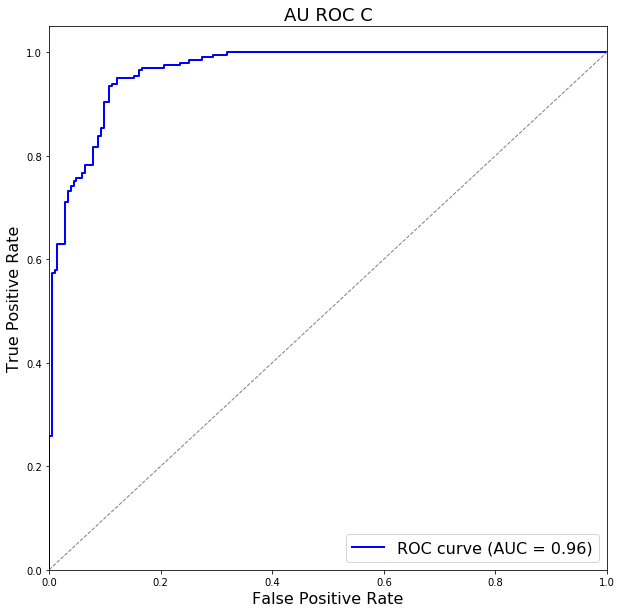

In [20]:
# Calculate stats for ROC AUC plot
fpr_agg, tpr_agg, thresholds_agg = roc_curve(y_val, preds)
roc_auc_agg = auc(fpr_agg, tpr_agg)

# Plot ROC AUC
plt.figure(figsize=(10,10))
plt.plot(fpr_agg, tpr_agg, color='blue',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_agg)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('AU ROC C', fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [21]:
# Optimize threshold
thresholds_agg[np.argmax(tpr_agg - fpr_agg)]

0.35415706

In [22]:
# Threshold prediction probabilities to binary classes
out_prob_threshold = 0.35
preds_class = np.where(preds > out_prob_threshold, 1, 0)

In [23]:
# Look at classification metrics
print(classification_report(y_val, preds_class))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       204
           1       0.88      0.95      0.91       197

    accuracy                           0.91       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.92      0.91      0.91       401



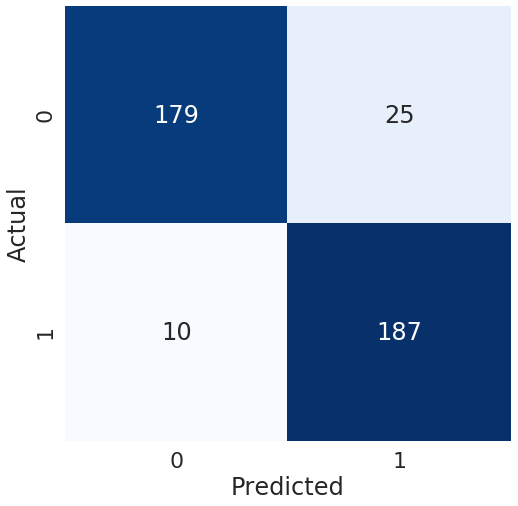

In [24]:
# Plot confusion matrix
plot_cm(y_val, preds_class)

---
### Make submission

In [ ]:
# Fit model on all the training data, make sure to sync all params, especially epochs.
# There would be leakage if we used any train data to validate, so no early stopping.

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [#EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
             tensorboard_callback]

model = get_model()

model.compile(loss='binary_crossentropy',
          optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
          metrics=['accuracy'])

batch_size=64
generator = gen.flow(X_train_all, np.array(y_train_all), batch_size=batch_size)

model.fit_generator(generator,
                    steps_per_epoch=batch_size,
                    epochs=60,
                    callbacks=callbacks,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_val, y_val))

In [ ]:
model = load_model('best_model.h5')

In [ ]:
preds = model.predict(X_test)

In [ ]:
preds[:20]

In [ ]:
# Create submission file
submission_fn = 'data_aug2.csv'
submission = pd.DataFrame()
submission['id']=test_df['id']
submission['is_iceberg']=preds.reshape((preds.shape[0]))
submission.to_csv('submissions/'+submission_fn, index=False)

---
### Make submission from ensemble of best k-fold validaton models

In [ ]:
submission_fn = 'ensemble.csv'
submission = pd.DataFrame()
submission['id']=test_df['id']
for i in range(k):
    model = load_model('best_model_'+str(i)+'.h5')
    preds = model.predict(X_test)
    submission[i] = preds.reshape((preds.shape[0]))
    

In [ ]:
submission.iloc[:, 1:6]

In [ ]:
submission['is_iceberg'] = submission.iloc[:, 1:6].mean(axis=1)
submission

In [ ]:
submission[['id','is_iceberg']].to_csv('submissions/'+submission_fn, index=False)